# <span id="chap_concepts_components"></span> Connectivity, components, and cliques 

Networks consist of nodes connected by edges. We've already looked at the notion of a [path](concepts-paths.ipynb) in terms of providing a "rouyute to follow" to get from one node to another. We can look at paths between pairs of nodes to see whether they exist &ndash; is it possible to navigate from one node to the other? &ndash; and find paths of different lengths, including a possibly unique [shortest path](concepts.paths.ipynb#sec_concepts_paths_shortest). We also considered one way of raising this local property to the global network level in order to find the network's [diameter](concepts.paths.ipynb#sec_concepts_paths_diameter): in the network as a whole, what is the longest shortest path between *any* pair of nodes?

There's another such global question related to paths: is it always possible to find a path between any pair of nodes in the network? Clearly there's a major difference between networks for which the answer is yes, and other networks: in the former case, while it may be *hard* to find a path between tweo nodes, it will always be *possible*; in the latter case, some attempts at navigation are doomed to failure.

## <span id="sec_concepts_components_connectivity"></span> Connectivity

A network for which there is always a path between any pair of nodes is called **connected**. Connectivity is the property that says that navigation is always possible.

How do we determine if a network is connected? At some level we need to check that paths exist between all pairs of nodes, but that's going to be extremely expensive for large networks. Fortunately there's a simpler way, and even more fortunately `networkx` provides it built-in.

In [1]:
import networkx
import numpy
import itertools

import cncp

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn

/Users/sd/programming/cncp/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Let's start with a network we know to be connected, our old faithful lattice. We can use `networkx`'s `is_connected()` function to test the network's connectivity:

In [2]:
l = cncp.lattice_graph(10, 10)
print 'Lattice connected? {c}'.format(c = networkx.is_connected(l))

Lattice connected? True


No surprises there. Can we generate an un-connected network? the simplest option would simply be to add another node to the lattice and not add an edge connecting it. Then adding an edge to connect it to the main "body" of the lattice should re-connect the network as a whole:

In [3]:
l.add_node(9999)
print 'Lattice with extra node connected? {c}'.format(c = networkx.is_connected(l))

l.add_edge(9999, 1)
print 'Did the new edge re-connect things? {c}'.format(c = networkx.is_connected(l))

Lattice with extra node connected? False
Did the new edge re-connect things? True


We can also take a connected network and **disconnect** it by removing nodes, for example by "snipping off the corner":

In [4]:
l.remove_edges_from([ (0, 1), (0, 10) ])
print 'Still connected? {c}'.format(c = networkx.is_connected(l))

Still connected? False


This works because we happen to know the way the nodes are labelled by `lattice_graph()`, so we know which edges we need to remove. We could also have removed a band of edges across the centre of the lattice, or on a diagonal: as longf as we interrupt the path between *any one pair* of nodes, the network will no longer be connected. 

These ideas work with larger groups of nodes as well. For example, suppose we place two networks "side by side", having edges internally but none between them:

In [5]:
# create two lattices
l1 = cncp.lattice_graph(5, 5)
l2 = cncp.lattice_graph(5, 5)

# re-label the second lattice so that the node labels will be unique
l2p = networkx.relabel_nodes(l2, lambda n: n + 1000)

# combine the two lattices together to form a single network
l = networkx.compose(l1, l2p)

print 'Two-lattice network connected? {c}'.format(c = networkx.is_connected(l))

Two-lattice network connected? False


Notice what we did to make this work:

1. we built the two networks independently ;
1. then we re-labelled one of them to make the node labels unique; and
1. then composed them together. 

Our lattice-creation function always labels nodes in the same way in the networks it creates, so after the first step we have two networks each with a common set of node labels. If we'd simply composed these networks together as-is, `networkx` would have assumed that two nodes with the same label were *the same node* and would have combined them &ndash; and then combined all the edges too. We'd have ended up with a single lattice! By re-labelling the second network's nodes we ensure they're recognised as distinct, and therefore when we combine the two networks we get a a network with two lattices "side by side" and no edges between them.

Adding a single edge between nodes in the two lattices is of course enough to connect the network:

In [6]:
l.add_edge(0, 1000)
print 'Two-lattice network connected with extra edge? {c}'.format(c = networkx.is_connected(l))

Two-lattice network connected with extra edge? True


Finally, we could also disconnect a network if we remove a node that is "critical" to the connectivity, since removing a node by definition removes any edges it is incident upon. So if we remove one of the nodes we just used as end-points when connecting the two lattices, they will disconnect again:

In [7]:
l.remove_node(1000)
print 'Is the network still connected after removing a critical node? {c}'.format(c = networkx.is_connected(l))

Is the network still connected after removing a critical node? False


And of course one of the "lattices" is now missing a node.

## <span id="sec_concepts_components_components"></span> Components

Let's return to the lattices we used to create the network above. Each of the lattices was itself a network, which we then joined together to firm the overall lattices-side-by-side network. But we can also observe that &ndash; in this case, although not necessarily &ndash; the two lattices were themselves connected. It was possible to go from any node in one lattice to any node *in the same lattice*; when we put them side-by side, this stopped being the case; and then when we added an edge it because possible to go from any node in one lattice to any node *in either lattice*.

So after we placed the lattices side-by-side we had a network with two **sub-networks**, each of which was connected, but the network taken together was disconnected. This property of being a connected sub-network of a larger structure is called being a **component** (or sometimes a **connected component**, although that's a bit tautologous). When we connected the two components together we created a single connected network, a single component.

Each component is a "island" of connectivity. Navigation is possible "on the island", but impossible "off the island". The number of components in a network is a measure of how many "islands" there are. We can use `networkxz` to count both their number and their size:

In [8]:
print "Newly-split network as {c} components".format(c = networkx.number_connected_components(l))

# compute the sizes of the components
cs = list(networkx.connected_components(l))
for i in range(len(cs)):
    print 'Component {i} contains {n} nodes'.format(i = i, n = len(cs[i]))

Newly-split network as 2 components
Component 0 contains 24 nodes
Component 1 contains 25 nodes


The components are returned in a fairly arbitrary order, so if we want the largest (or smallest) we need to use `max()` or `sorted()` to explicitly put them into the right order: 

In [9]:
print 'Largest component has {n} nodes'.format(n = len(max(networkx.connected_components(l), key = len)))

Largest component has 25 nodes


### <span id="sec_concepts_components_ensuring"></span> Making sure we have a connected network

The significance of components really becomes clear when we consider different ways of generating networks, especially using random processes. Many such processes don't actually guarantee to generate a connected network: they add edges between nodes randomly, so it's entirely possible that some nodes may be isolated or that two or more components may form. If this is important for an application, we need to be careful to make sure the network is connected *before* we start work on it. There are two basic ways to do this:

1. we can check that the network is connected using `is_connected()`, and throw it away and start again; or
1. we can take the largest component from the network as-is.

Neither method is necessarily better. For the first, it might be that we *never* get a connected network because of some combination of parameters to the generator (for example the network has three nodes and we only ever add one edge: extreme, but you get the idea). For the second, we'll necessarily end up with a network that has fewer nodes than we thought: possibly less than half, depending on exactly how many components the generator gives rise to. So which method we adopt depends on the application, and we'll have to think carefully about the constraints of each scenario we explore.

## <span id="sec_concepts_components_almost_very"></span> *Really*- and *almost*-components

There are two final topics we should consider before we move on. Firstly, is a component is just a connected sub-network, is there a "most connected" sub-network that weould be the most component-y component we could imagine? Secondly, what happens to sub-networks that aren't *quite* components? 

### <span id="sec_concepts_components_cliques"></span> Cliques

What is the most connected network we can imagine? At one level this makes no sense: a network is connected, or it isn't. But at another level, it makes perfect sense: just by inspection, the two networks below exhibit qualitatively different connectivities:

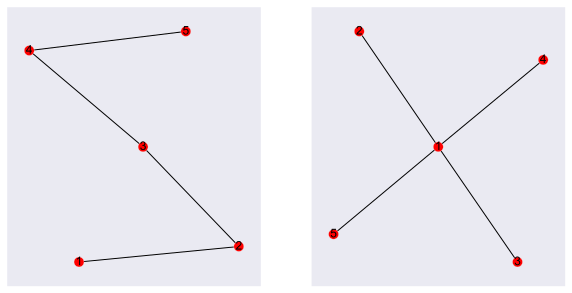

In [10]:
# build left network
l = networkx.Graph()
l.add_edges_from([ (1, 2), (2, 3), (3, 4), (4, 5) ])

# build left network
r = networkx.Graph()
r.add_edges_from([ (1, 2), (1, 3), (1, 4), (1, 5) ])

# create the figure
fig = plt.figure(figsize = (10, 5))

# draw left network
ax1 = fig.add_subplot(1, 2, 1) # one row of two columns, first box
ax1.grid(False)                # no grid
ax1.get_xaxis().set_ticks([])  # no ticks on the axes
ax1.get_yaxis().set_ticks([])
networkx.draw_networkx(l, ax = ax1, node_size = 100)

# draw right network
ax2 = fig.add_subplot(1, 2, 2) # one row of two columns, second box
ax2.grid(False)                # no grid
ax2.get_xaxis().set_ticks([])  # no ticks on the axes
ax2.get_yaxis().set_ticks([])
networkx.draw_networkx(r, ax = ax2, node_size = 100)

To be clear, these two networks have the same number of nodes, the same number of edges, and are both connected &ndash; so what's different? Well their diameters for a start:

In [11]:
print 'Left network diameter {ld}.'.format(ld = networkx.diameter(l))
print 'Right network diameter {ld}.'.format(ld = networkx.diameter(r))

Left network diameter 4.
Right network diameter 2.


Clearly it's "quicker to get around" the right-hand network. So what would be the "quickest" network we could imagine? The minimum case is when the diameter of the network is 1. Remembering the [definition of diameter](concepts-paths.ipynb#sec_concepts_paths_diameter) as the longest shortest path, this would mean that the shortest path between any pair of nodes was 1 &ndash; or, to put it another way, every node was adjacent to every other. Such a network is called a **clique** (which rhymes with "speak", *not* with "click"). In the graph theory literature, the clique of $n$ nodes is referred to as $K_n$. 

We can create cliques algorithmically:

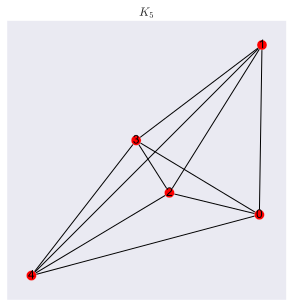

In [12]:
# create a clique of five nodes
k5 = networkx.Graph()
for (n, m) in itertools.combinations(range(5), 2):
    k5.add_edge(n, m)
    
# draw the clique
fig = plt.figure(figsize = (5, 5))
ax = fig.gca()
ax.grid(False)                # no grid
ax.get_xaxis().set_ticks([])  # no ticks on the axes
ax.get_yaxis().set_ticks([])
networkx.draw_networkx(k5, node_size = 100)
plt.title('$K_5$')
_ = plt.show()

If you're not familiar with Python's `itertools` package, it provides a whole suite of useful ways to combine sets of data. `itertools.combinations()` takes a collection `l` and a number `i` and produces all combinations of `i` objects taken from `l` &ndash; in this case all pairs of nodes, with each pair appearing exactly once.

`networkx` will, unsurprisingly, create cliques directly:

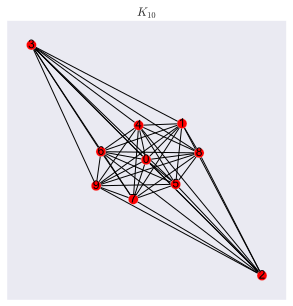

In [13]:
fig = plt.figure(figsize = (5, 5))
ax = fig.gca()
ax.grid(False)                # no grid
ax.get_xaxis().set_ticks([])  # no ticks on the axes
ax.get_yaxis().set_ticks([])
networkx.draw_networkx(networkx.complete_graph(10), node_size = 100)
plt.title('$K_{10}$')
_ = plt.show()

Another way to think of a clique is that it is a [simple network](concepts-simple-network.ipynb) with the maximum possible number of edges &ndash; since simple networks only have at most one edge between any pair of nodes (no [parallel edges](concepts-simple-network.ipynb#concepts_simple_network_parallel_edges)), and no [self-loops](concepts-simple-network.ipynb#concepts_simple_network_selfloops). The ratio between the number of edges a network has and the number it *could* have is sometimes referred to as its **density**. It isn't a measure of connectivity *per se*, but can provide a useful metric for deciding whether a network is well-connected or sparse &ndash; concepts we'll come back to later.

### <span id="sec_concepts_components_communities"></span> Communities

In the lattices-side-by-side example [above](#sec_concepts_components_connectivity) we had two components that we connected with a single edge. Suppose we scale things up a bit, to a large network with several large components. Suppose we then add a small number of edges between the components, thereby connecting the network. We now have a connected network and a single component: is there anything else to say about the matter?

Well clearly there is. The sub-networks are no longer components, it's true, but they're still recognisibly more connected *within* themselves than *between* themselves. We refer to these almost-components as **communities** or **modules**.

While the idea of being a component is very clear-cut, being a community is a lot more delicate. When is a collection of nodes "connected enough" internally and "not connected enouygh" externally to be termed a community? Can we always identify the communities of a network? As the number of edges increases, and the number of paths between pairs of nodes in two communities increases, at what point do they cease to be two communities and become one?

These are all interesting questions, which we'll return to later: the notion of community-finding is a very active research topic For the time being, it's sufficient to observe that the component (or community) structure of a network might have an influence on its properties, and in particular on how processes operate over it.